# SWOT data exploration

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from skimage import exposure
from skimage.io import imsave, imread
from osgeo import ogr
import pystac_client
from pyproj import Transformer
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import geopandas as gpd
import pandas as pd
import geoviews as gv
import hvplot.pandas
import intake
import xarray as xr
import numpy as np
from numpy.random import default_rng
import intake
from pyproj import Proj, transform
from osgeo import gdal
from sklearn.neighbors import BallTree
import earthaccess
import datetime as dt

# for progress bar
from ipywidgets import IntProgress
from IPython.display import display
import time
from tqdm.notebook import trange, tqdm

import boto3
import rasterio as rio
from rasterio.features import rasterize
from rasterio.session import AWSSession
import dask
import os
import rioxarray
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.warp import Resampling as resample
import cartopy.crs as ccrs
import cartopy
import scipy
import statsmodels.formula.api as smf
from shapely.geometry.polygon import Polygon, Point
import pygmt
import gc
import pytz
import pyproj
from pathlib import Path
import pprint

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [3]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # Ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [4]:
bbox = (-73, 35, -70, 37) # west, south, east, north
start_dt = '2024-05-07'
end_dt = '2024-05-10'

In [5]:
# Gather all files from search location and time
results = earthaccess.search_data(
    short_name='SWOT_L2_LR_SSH_UNSMOOTHED_2.0',
    bounding_box=bbox,
    temporal=(start_dt, end_dt)
)
print (f'{len(results)} TOTAL granules')

Granules found: 4
4 TOTAL granules


In [6]:
# Gather all files from search location and time
resultsE = earthaccess.search_data(
    short_name='SWOT_L2_LR_SSH_EXPERT_2.0',
    bounding_box=bbox,
    temporal=(start_dt, end_dt)
)
print (f'{len(resultsE)} TOTAL granules')

Granules found: 4
4 TOTAL granules


In [13]:
# To image 1 day
ds = xr.open_dataset(earthaccess.open(results[0:2])[1], group='left',engine='h5netcdf')

# Adjust the longitude by subtracting 180
if 'longitude' in ds.coords:
    if ds['longitude'].max()>180:
        ds['longitude'] = ds['longitude'] - 180
elif 'lon' in ds.coords:
    if ds['lon'].max()>180:
        ds['lon'] = ds['lon'] - 180

# Create a mask for the desired latitude range
mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2]) & (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
# Check if the mask is valid (non-empty)
if mask.sum() == 0:
    mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2])
    if mask.sum() == 0:
        mask = (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
    
# Apply the mask to slice the dataset
ds_masked = ds.where(mask, drop=True)

# # Flatten the latitude and longitude coordinates
# lat = ds_masked.latitude.values.ravel()
# lon = ds_masked.longitude.values.ravel()
# ssh_karin_2 = ds_masked.ssh_karin_2.values.ravel()

# # Create a mask to filter out non-finite values
# mask = np.isfinite(lat) & np.isfinite(lon) & np.isfinite(ssh_karin_2)

# # Apply the mask to the data
# lat = lat[mask]
# lon = lon[mask]
# ssh_karin_2 = ssh_karin_2[mask]

Opening 2 granules, approx size: 1.39 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(ds_masked.longitude,ds_masked.latitude,ds_masked,cmap='coolwarm')
cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('SLA', rotation=270)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.show()

In [ ]:
# 'SWOT_L2_LR_SSH_UNSMOOTHED_2.0'
# dsl = xr.open_dataset(path, group='left', engine='h5netcdf')
# dsr = xr.open_dataset(path, group='right', engine='h5netcdf')

# 'SWOT_L2_LR_SSH_EXPERT_2.0'
# ds = xr.open_dataset(path)

## Multi-image processing

In [7]:
def crop_unsmoothswot_datarray(path,bbox,var='ssh_karin_2'):
    # Open Unsmoothed
    # Does not add time dimension
    
    # Open left and right swaths
    dsl = xr.open_dataset(path, group='left')
    dsr = xr.open_dataset(path, group='right')
    
    # Concatenate the data, longitude and latitude coordinates
    ds = xr.concat([dsl[var], dsr[var]], dim='num_lines')
    longitude = xr.concat([dsl['longitude'], dsr['longitude']], dim='num_lines')
    latitude = xr.concat([dsl['latitude'], dsr['latitude']], dim='num_lines')
    
    # Assign the concatenated coordinates back to the dataset
    ds = ds.assign_coords({
        'longitude': longitude,
        'latitude': latitude
    })
    
    if 'longitude' in ds.coords:
        if ds['longitude'].max()>180:
            ds['longitude'] = ds['longitude'] - 180
    
    # Create a mask for the desired latitude range
    mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2]) & (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
    print(mask.sum())
    # Check if the mask is valid (non-empty)
    if mask.sum() == 0:
        mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2])
        if mask.sum() == 0:
            print('Mask via longitude only')
            mask = (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
            print(mask.sum())
        else:
            print('Mask via latitude only')
            print(mask.sum())
        
    # Apply the mask to slice the dataset
    ds_masked = ds.where(mask, drop=True)

    return ds_masked

In [8]:
def crop_unsmoothswot_dataset(path,bbox,var='ssh_karin_2'):
    # Open Unsmoothed
    # Adds time dimension

    # Open left and right swaths
    dsl = xr.open_dataset(path, group='left')
    dsr = xr.open_dataset(path, group='right')
    
    # Concatenate the data variables and coordinates
    ssh_karin_2 = xr.concat([dsl[var], dsr[var]], dim='num_lines')
    longitude = xr.concat([dsl['longitude'], dsr['longitude']], dim='num_lines')
    latitude = xr.concat([dsl['latitude'], dsr['latitude']], dim='num_lines')
    
    # Create a new Dataset
    ds = xr.Dataset({
        var: ssh_karin_2
    },
    coords={
        'longitude': longitude,
        'latitude': latitude
    })
    
    # Adding a date as a coordinate or data variable
    ds['date'] = [np.datetime_as_string(dsl.time[0], unit='D')]
    
    # Adjust the longitude if necessary
    if ds['longitude'].max() > 180:
        ds['longitude'] = ds['longitude'] - 180
    
    # Create a mask for the desired latitude range
    mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2]) & (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
    print(mask.sum())
    
    # Check if the mask is valid (non-empty)
    if mask.sum() == 0:
        mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2])
        if mask.sum() == 0:
            print('Mask via longitude only')
            mask = (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
            print(mask.sum())
        else:
            print('Mask via latitude only')
            print(mask.sum())
        
    # Apply the mask to slice the dataset
    ds_masked = ds.where(mask, drop=True)

    return ds_masked

In [11]:
def crop_expertswot_dataset(path,bbox):
    
    ds = xr.open_dataset(path)
    
    # Adjust the longitude if necessary
    if ds['longitude'].max() > 180:
        ds['longitude'] = ds['longitude'] - 180

    ds['date'] = [np.datetime_as_string(ds.time[-1], unit='D')]
        
    # Create a mask for the desired latitude range
    mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2]) & (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
    print(mask.sum())
    
    # Check if the mask is valid (non-empty)
    if mask.sum() == 0:
        mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2])
        if mask.sum() == 0:
            print('Mask via longitude only')
            mask = (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
            print(mask.sum())
        else:
            print('Mask via latitude only')
            print(mask.sum())
        
    # Apply the mask to slice the dataset
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

In [9]:
pathsE = earthaccess.open(resultsE)
paths = earthaccess.open(results)

Opening 4 granules, approx size: 0.13 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

Opening 4 granules, approx size: 2.69 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
# Open Expert
i = 0
dsE = crop_expertswot_dataset(pathsE[i],bbox)

<xarray.DataArray ()> Size: 8B
array(0)
Mask via longitude only
<xarray.DataArray 'latitude' ()> Size: 8B
array(7828)


In [13]:
ds = crop_unsmoothswot_dataset(paths[i],bbox)

<xarray.DataArray ()> Size: 8B
array(0)
Mask via longitude only
<xarray.DataArray 'latitude' ()> Size: 8B
array(447236)


In [78]:
dsE.ssh_karin_2

<xarray.DataArray 'ssh_karin_2' (num_lines: 128, num_pixels: 69)> Size: 71kB
array([[     nan,      nan,      nan, ..., -42.2215,      nan,      nan],
       [     nan,      nan,      nan, ..., -42.2535,      nan,      nan],
       [     nan,      nan,      nan, ..., -42.2675,      nan,      nan],
       ...,
       [     nan, -43.7561, -43.7591, ...,      nan,      nan,      nan],
       [     nan, -43.7763, -43.79  , ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
    latitude         (num_lines, num_pixels) float64 71kB 37.25 37.24 ... 34.75
    longitude        (num_lines, num_pixels) float64 71kB 110.6 110.6 ... 109.8
    latitude_nadir   (num_lines) float64 1kB 37.12 37.1 37.09 ... 34.9 34.88
    longitude_nadir  (num_lines) float64 1kB 289.9 289.9 289.9 ... 290.5 290.5
Dimensions without coordinates: num_lines, num_pixels
Attributes:
    long_name:      sea surface height
    standard_name:  sea surface height above reference ellipsoid
    units:          m
    quality_flag:   ssh_karin_2_qual
    valid_min:      -15000000
    valid_max:      150000000
    comment:        Fully corrected sea surface height measured by KaRIn. The...

In [79]:
ds.ssh_karin_2

<xarray.DataArray 'ssh_karin_2' (num_lines: 2025, num_pixels: 233)> Size: 4MB
array([[-41.7477, -41.7547,      nan, ...,      nan,      nan,      nan],
       [-41.7411, -41.7435, -41.7847, ...,      nan,      nan,      nan],
       [-41.7249, -41.7295, -41.7619, ...,      nan,      nan,      nan],
       ...,
       [-44.2906, -44.2963, -44.279 , ...,      nan,      nan,      nan],
       [-44.2561, -44.2723, -44.2895, ...,      nan,      nan,      nan],
       [-44.2649, -44.2696, -44.3211, ...,      nan,      nan,      nan]])
Coordinates:
    latitude   (num_lines, num_pixels) float64 4MB 37.0 37.0 ... 34.89 34.89
    longitude  (num_lines, num_pixels) float64 4MB 110.0 110.0 ... 109.8 109.8
Dimensions without coordinates: num_lines, num_pixels
Attributes:
    long_name:      sea surface height
    standard_name:  sea surface height above reference ellipsoid
    units:          m
    quality_flag:   ssh_karin_2_qual
    valid_min:      -15000000
    valid_max:      150000000
    comment:        Fully corrected sea surface height measured by KaRIn. The...

In [82]:
# Interpolate the low-resolution data to the high-resolution grid
dsE_interp = dsE.interp(latitude=ds.latitude,longitude=ds.longitude, 
                        method="linear"  # You can choose other methods like 'nearest', 'cubic', etc.
)

ValueError: Dimensions {'longitude', 'latitude'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'num_lines': 128, 'num_pixels': 69, 'num_sides': 2, 'date': 1})

In [14]:
%pip install xesmf

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import xesmf as xe

# Assuming low_res_da and high_res_da are your DataArray objects

# Create a function to generate a grid dataset from DataArray coordinates
def create_grid(da):
    lon, lat = np.meshgrid(da.longitude.values, da.latitude.values)
    return xr.Dataset({
        'lon': (('y', 'x'), lon),
        'lat': (('y', 'x'), lat)
    })

# Create source and destination grids
src_grid = create_grid(dsE)
dst_grid = create_grid(ds)


In [ ]:
# Create a regridder object
regridder = xe.Regridder(src_grid, dst_grid, 'bilinear')  # You can also use 'nearest_s2d', 'conservative', etc.

# Regrid the data
low_res_interp = regridder(dsE)


In [ ]:
# Add the two datasets
combined_da = low_res_interp + high_res_da


In [ ]:
combined_da = low_res_interp.combine_first(high_res_da)


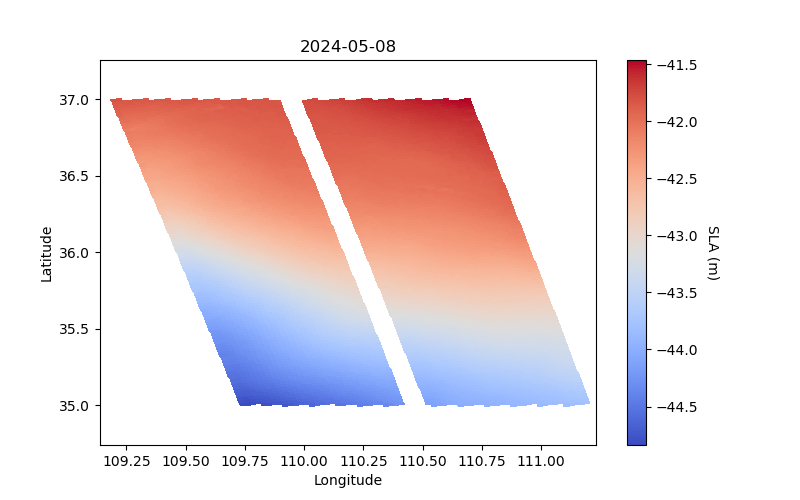

In [65]:
plt.clf()

data = dsE
fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(data.longitude,data.latitude,np.add(data.ssh_karin_2,data.height_cor_xover),cmap='coolwarm')#,vmin=-48,vmax=-43)
cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('SLA (m)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(data.date.values[0])

plt.show()

In [9]:
# Open Unsmoothed

paths = earthaccess.open(results)

i = 0

dsl = xr.open_dataset(paths[i], group='left')
dsr = xr.open_dataset(paths[i], group='right')

# Concatenate the data variables and coordinates
ssh_karin_2 = xr.concat([dsl['ssh_karin_2'], dsr['ssh_karin_2']], dim='num_lines')
longitude = xr.concat([dsl['longitude'], dsr['longitude']], dim='num_lines')
latitude = xr.concat([dsl['latitude'], dsr['latitude']], dim='num_lines')

# Create a new Dataset
ds = xr.Dataset({
    'ssh_karin_2': ssh_karin_2
},
coords={
    'longitude': longitude,
    'latitude': latitude
})

# Adding a date as a coordinate or data variable
ds['date'] = [np.datetime_as_string(dsl.time[0], unit='D')]

# Adjust the longitude if necessary
if ds['longitude'].max() > 180:
    ds['longitude'] = ds['longitude'] - 180

# Create a mask for the desired latitude range
mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2]) & (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
print(mask.sum())

# Check if the mask is valid (non-empty)
if mask.sum() == 0:
    mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2])
    if mask.sum() == 0:
        print('Mask via longitude only')
        mask = (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
        print(mask.sum())
    else:
        print('Mask via latitude only')
        print(mask.sum())
    
# Apply the mask to slice the dataset
ds_masked = ds.where(mask, drop=True)

<xarray.DataArray ()> Size: 8B
array(0)
Mask via longitude only
<xarray.DataArray 'latitude' ()> Size: 8B
array(447236)


In [12]:
i = 0

dsl = xr.open_dataset(paths[i], group='left', engine='h5netcdf')
dsr = xr.open_dataset(paths[i], group='right', engine='h5netcdf')

# Concatenate the data variables and coordinates
ssh_karin_2 = xr.concat([dsl['ssh_karin_2'], dsr['ssh_karin_2']], dim='num_lines')
longitude = xr.concat([dsl['longitude'], dsr['longitude']], dim='num_lines')
latitude = xr.concat([dsl['latitude'], dsr['latitude']], dim='num_lines')

# Create a new Dataset
ds = xr.Dataset({
    'ssh_karin_2': ssh_karin_2
},
coords={
    'longitude': longitude,
    'latitude': latitude
})

# Adding a date as a coordinate or data variable
ds['date'] = [np.datetime_as_string(dsl.time[0], unit='D')]

# Adjust the longitude if necessary
if ds['longitude'].max() > 180:
    ds['longitude'] = ds['longitude'] - 180

# Create a mask for the desired latitude range
mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2]) & (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
print(mask.sum())

# Check if the mask is valid (non-empty)
if mask.sum() == 0:
    mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2])
    if mask.sum() == 0:
        print('Mask via longitude only')
        mask = (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
        print(mask.sum())
    else:
        print('Mask via latitude only')
        print(mask.sum())
    
# Apply the mask to slice the dataset
ds_masked = ds.where(mask, drop=True)

<xarray.DataArray ()> Size: 8B
array(0)
Mask via longitude only
<xarray.DataArray 'latitude' ()> Size: 8B
array(894665)


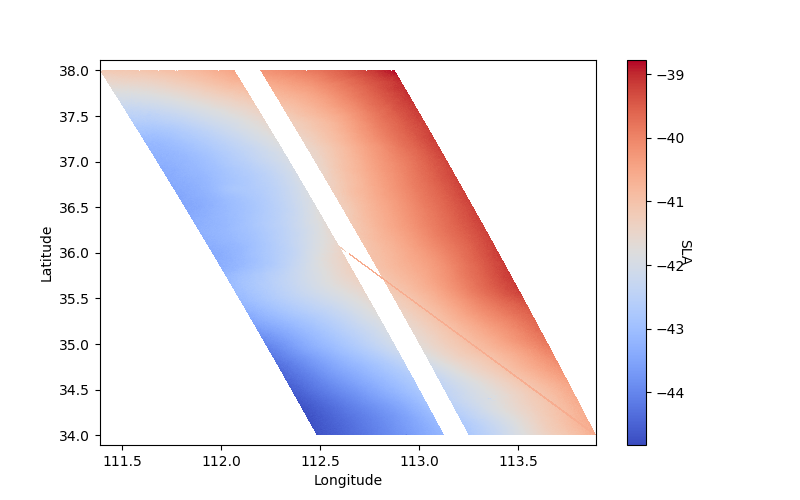

In [14]:
fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(ds_masked.longitude,ds_masked.latitude,ds_masked.ssh_karin_2,cmap='coolwarm')
cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('SLA', rotation=270)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.show()

In [22]:
%%time
# Multi-day dataset

paths = earthaccess.open(results)

# Construct xarray for scene
days = []
for path in paths[0:3]:
    ds = crop_unsmoothswot_dataset(path,bbox)
    days.append(ds)
    print(i)
swot = xr.concat(days, dim='date')
# ls_scene.coords['id'] = sceneid.id
# ls_scene.coords['time'] = item.metadata['datetime'].strftime('%Y-%m-%dT%H:%M:%S')
# ls_scene = ls_scene['band_data']

Opening 25 granules, approx size: 15.74 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/25 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/25 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/25 [00:00<?, ?it/s]

<xarray.DataArray ()> Size: 8B
array(0)
Mask via longitude only
<xarray.DataArray 'latitude' ()> Size: 8B
array(894665)
1
<xarray.DataArray ()> Size: 8B
array(0)
Mask via longitude only
<xarray.DataArray 'latitude' ()> Size: 8B
array(894665)
1
<xarray.DataArray ()> Size: 8B
array(0)
Mask via longitude only
<xarray.DataArray 'latitude' ()> Size: 8B
array(894665)
1
CPU times: user 29.9 s, sys: 10.2 s, total: 40.1 s
Wall time: 1min 2s


# Test code

In [5]:
#retrieves granule from the day we want
karin_results = earthaccess.search_data(short_name = 'SWOT_L2_LR_SSH_EXPERT_2.0', 
                                        bounding_box=bbox, 
                                        temporal=(start_dt, end_dt))

Granules found: 21


In [6]:
#opens granules and load into xarray dataset
ds = xr.open_mfdataset(earthaccess.open(karin_results[0:12]), combine='nested', concat_dim="num_lines", decode_times=False, engine='h5netcdf')
ds

Opening 12 granules, approx size: 0.39 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/12 [00:00<?, ?it/s]

<xarray.Dataset> Size: 5GB
Dimensions:                                (num_lines: 118392, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    latitude_nadir                         (num_lines) float64 947kB dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir                        (num_lines) float64 947kB dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/98)
    time                                   (num_lines) float64 947kB dask.array<chunksize=(9866,), meta=np.ndarray>
    time_tai                               (num_lines) float64 947kB dask.array<chunksize=(9866,), meta=np.ndarray>
    ssh_karin                              (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssh_karin_qual                         (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssh_karin_uncert                       (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssha_karin                             (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ...                                     ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 33MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 33MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 33MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 33MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    volumetric_correlation                 (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    volumetric_correlation_uncert          (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2024-01-05T21:19:25Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       64.08514221672752
    ssha_variance:                                 1.3903190024565364
    references:                                    V1.2.1
    equator_longitude:                             -49.14

In [7]:
ds['ssh_karin_2_corrected'] = ds.ssh_karin_2 + ds.height_cor_xover
ds['ssha_karin_corrected'] = ds.ssha_karin + ds.height_cor_xover
ds.ssh_karin_2_corrected

<xarray.DataArray 'ssh_karin_2_corrected' (num_lines: 118392, num_pixels: 69)> Size: 65MB
dask.array<add, shape=(118392, 69), dtype=float64, chunksize=(9866, 69), chunktype=numpy.ndarray>
Coordinates:
    latitude         (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    longitude        (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    latitude_nadir   (num_lines) float64 947kB dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir  (num_lines) float64 947kB dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels

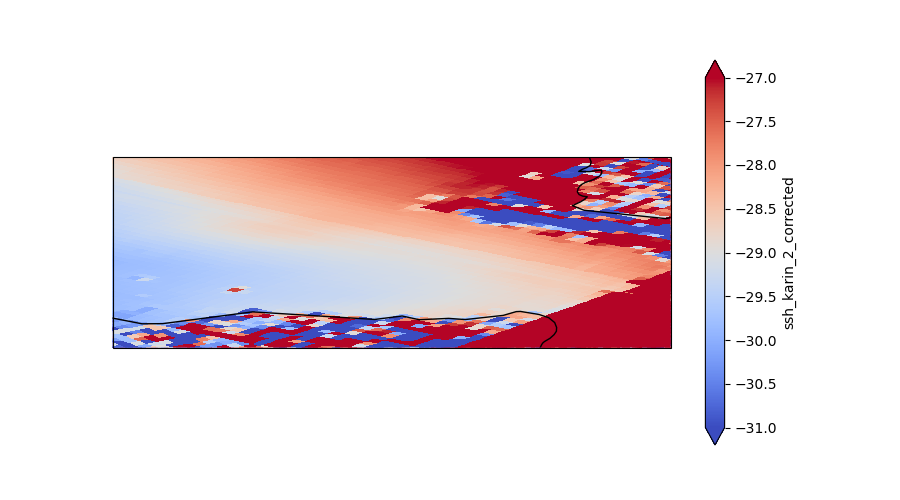

In [13]:
plt.figure(figsize=(9, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Set the latitude and longitude limits
# ax.set_extent([-110, -99, -75.44, -71], crs=ccrs.PlateCarree())
ax.set_extent([-104.1, -100.9, -75.29, -74.2], crs=ccrs.PlateCarree())

ds.ssh_karin_2_corrected.plot.pcolormesh(
 ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", vmin=-31, vmax=-27, cmap='coolwarm', add_colorbar=True
) # vmin=-12, vmax=5,
ax.coastlines()